In [1]:
import os, zipfile
from zipfile import ZipFile
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from visualizations import *
from language import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Montando o setup do Kaggle

In [2]:
if 'google.colab' in str(get_ipython()):
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle/"
    on_colab = True
    ! pip install kaggle --upgrade
else:
    os.environ['KAGGLE_CONFIG_DIR'] = "../../Kaggle/"
    on_colab = False

In [3]:
# Downloading and extracting the data from Kaggle
if on_colab:
    dataset_folder = "./"
    ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis
    ! unzip -q i2a2-nlp-2021-sentiment-analysis.zip -d "./i2a2-nlp-2021-sentiment-analysis/"
    ! rm i2a2-nlp-2021-sentiment-analysis.zip
else:
    dataset_folder = "C:\\Users\\weldl\\datasets\\i2a2-nlp-2021-sentiment-analysis"
    if not os.path.isdir(dataset_folder):
        ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis -p "C:\\Users\\weldl\\datasets"
        # Create a ZipFile Object and load sample.zip in it
        zip_file = dataset_folder + ".zip"
        with ZipFile(zip_file, 'r') as zipObj:
           # Extract all the contents of zip file in different directory
           zipObj.extractall(dataset_folder)
        os.remove(zip_file)

In [4]:
df_train = pd.read_csv(os.path.join(dataset_folder, "train.csv"), low_memory=False)
df_test = pd.read_csv(os.path.join(dataset_folder, "test.csv"), low_memory=False)

In [5]:
df_train.columns

Index(['id', 'submission_date', 'review_title', 'review_text', 'reviewer_id',
       'reviewer_birth_year', 'reviewer_gender', 'reviewer_state',
       'product_id', 'product_name', 'product_brand', 'site_category_lv1',
       'site_category_lv2', 'rating'],
      dtype='object')

In [6]:
df_train.head()

,id,submission_date,review_title,review_text,reviewer_id,reviewer_birth_year,reviewer_gender,reviewer_state,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,rating
0,0,2018-02-25 04:59:13,Americanas Nao tem compromisso,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,be7443b1b96702ad4599acbb8a034938c5df15f293ff72...,1981.0,F,PE,126831715,Google Chromecast 2,google,Informática e Acessórios,NaN,1
1,1,2018-03-12 10:13:18,muito bom produto,"Considerando seu custo, é ótimo som com muita ...",75792fad1da46e5ad1d81fd2fd94d6c1b43cacf87fc58d...,1956.0,M,SP,7954368,Caixa Multimidia 2.1 Com Subwoofer 21w Rms Sp-...,NaN,Informática e Acessórios,Periféricos,4
2,2,2018-01-12 17:20:44,Excelente!,Simplesmente é a melhor que já vi... ela é lin...,6793d62bea0e221898b4b47a2a7079be71c22ea0f35610...,1978.0,F,PR,132381765,"Smart TV LED 43"" Samsung 43MU6100 UHD 4K HDR P...",NaN,TV e Home Theater,TV,5
3,3,2018-03-21 18:18:44,Entrega antes do prazo!,Estou muito satisfeita com o produto é a entre...,ca3562dfc623df2e5055a1d33d8bdce778278e26fb65f1...,1986.0,F,RJ,129605351,"Smart TV LED 32"" SEMP TCL L32S4700S HD com Con...",semp tcl,TV e Home Theater,TV,4
4,4,2018-05-16 07:29:48,Muito bonito.,A gaiola é muito bonita. Colorida e grande. Al...,7e80e277a30db3bf89095683bf61d39dd8c933c9c7c8e2...,1976.0,F,PR,19956796,Gaiola Para Hamster 3 Andares Vermelha,NaN,Pet Shop,Roedores,3


In [7]:
df_test.columns

Index(['id', 'submission_date', 'review_title', 'review_text', 'reviewer_id',
       'reviewer_birth_year', 'reviewer_gender', 'reviewer_state',
       'product_id', 'product_name', 'product_brand', 'site_category_lv1',
       'site_category_lv2'],
      dtype='object')

In [8]:
df_test.head()

,id,submission_date,review_title,review_text,reviewer_id,reviewer_birth_year,reviewer_gender,reviewer_state,product_id,product_name,product_brand,site_category_lv1,site_category_lv2
0,0,2018-01-08 07:06:12,Muito bom equipamento!,"Recebi antes do programado, produto muito bom,...",d52fb901a01d5a94e7d8ff8675de0e97bf7d2dcad6d121...,1971.0,M,DF,119371001,Kit Aparador de Pelos Philips Multigroom QG333...,philips,Beleza e Perfumaria,Barbearia
1,1,2018-03-17 21:28:32,"Amei a estante, a cor é maravilhosa, atendeu a...","Só não é melhor, por este produto não ter pés,...",bbcb7b45aee2aeddcb39aa735284ed168916d7157a254e...,1968.0,F,DF,12637385,Estante Home Theater Para Tv De Até 55 Dimas A...,NaN,Móveis,"Rack, Estante e Painel"
2,2,2018-01-19 10:03:48,Bom!!,"O vidro é um pouco embaçado, mas como estava n...",b37a50e2b164666b485932252805bf66e95b092c98a294...,NaN,F,RJ,124845531,Conjunto de Potes Vidro 5 Peças com Tampa Bra...,euro home,Utilidades Domésticas,Utensílios e Acessórios Domésticos
3,3,2018-01-05 12:47:10,Cabo curto e frágil,Comprei o produto para facilitar meu dia-a-dia...,2e8910d28ef5d1d89ec20d8d632778f731d06d83fbcef8...,1979.0,F,SP,27632055,Balde Spin Mop 360° Centrifuga Em Inox Brinde ...,NaN,Utilidades Domésticas,Material de Limpeza
4,4,2018-04-29 19:58:20,Não recebi o produto,Não posso avaliar o produto pois não o recebi....,f3af7ad4de8d8b78655820ea3c0003bf2a12462e735b80...,1967.0,F,MS,170812,Livro - Quem Mexeu no Meu Queijo?,NaN,Livros,Administração e Negócios


# Data Preparation:

In [9]:
# Remove accents:
df_train['review_text_clean_accents'] = df_train['review_text'].apply(lambda x: strip_accents(x))
df_train[['review_text', 'review_text_clean_accents']].head()

,review_text,review_text_clean_accents
0,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 /12/ 2017 e ate agora...
1,"Considerando seu custo, é ótimo som com muita ...","Considerando seu custo, e otimo som com muita ..."
2,Simplesmente é a melhor que já vi... ela é lin...,Simplesmente e a melhor que ja vi... ela e lin...
3,Estou muito satisfeita com o produto é a entre...,Estou muito satisfeita com o produto e a entre...
4,A gaiola é muito bonita. Colorida e grande. Al...,A gaiola e muito bonita. Colorida e grande. Al...


In [10]:
# Remove punctuation:
df_train['review_text_clean'] = df_train['review_text_clean_accents'].apply(lambda x: remove_punct(x))
df_train[['review_text', 'review_text_clean_accents', 'review_text_clean']].head()

,review_text,review_text_clean_accents,review_text_clean
0,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 12 2017 e ate agora a...
1,"Considerando seu custo, é ótimo som com muita ...","Considerando seu custo, e otimo som com muita ...",Considerando seu custo e otimo som com muita q...
2,Simplesmente é a melhor que já vi... ela é lin...,Simplesmente e a melhor que ja vi... ela e lin...,Simplesmente e a melhor que ja vi ela e linda ...
3,Estou muito satisfeita com o produto é a entre...,Estou muito satisfeita com o produto e a entre...,Estou muito satisfeita com o produto e a entre...
4,A gaiola é muito bonita. Colorida e grande. Al...,A gaiola e muito bonita. Colorida e grande. Al...,A gaiola e muito bonita Colorida e grande Algu...


In [11]:
# Tokenization and convert to lower case:
df_train['review_text_tokenized'] = df_train['review_text_clean'].apply(lambda x: tokenize(x))
df_train[['review_text', 'review_text_clean_accents', 'review_text_clean', 'review_text_tokenized']].head()

,review_text,review_text_clean_accents,review_text_clean,review_text_tokenized
0,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 12 2017 e ate agora a...,"[comprei, um, tv, box, dia, 14, 12, 2017, e, a..."
1,"Considerando seu custo, é ótimo som com muita ...","Considerando seu custo, e otimo som com muita ...",Considerando seu custo e otimo som com muita q...,"[considerando, seu, custo, e, otimo, som, com,..."
2,Simplesmente é a melhor que já vi... ela é lin...,Simplesmente e a melhor que ja vi... ela e lin...,Simplesmente e a melhor que ja vi ela e linda ...,"[simplesmente, e, a, melhor, que, ja, vi, ela,..."
3,Estou muito satisfeita com o produto é a entre...,Estou muito satisfeita com o produto e a entre...,Estou muito satisfeita com o produto e a entre...,"[estou, muito, satisfeita, com, o, produto, e,..."
4,A gaiola é muito bonita. Colorida e grande. Al...,A gaiola e muito bonita. Colorida e grande. Al...,A gaiola e muito bonita Colorida e grande Algu...,"[a, gaiola, e, muito, bonita, colorida, e, gra..."


In [12]:
# Remove stopwords:
pt_stopwords = stopwords.words('portuguese')
df_train['review_text_nostop'] = df_train['review_text_tokenized'].apply(lambda x: remove_stopwords(x, pt_stopwords))
df_train[['review_text', 'review_text_clean_accents', 'review_text_clean', 'review_text_tokenized', 'review_text_nostop']].head()

,review_text,review_text_clean_accents,review_text_clean,review_text_tokenized,review_text_nostop
0,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 12 2017 e ate agora a...,"[comprei, um, tv, box, dia, 14, 12, 2017, e, a...","[comprei, tv, box, dia, 14, 12, 2017, ate, ago..."
1,"Considerando seu custo, é ótimo som com muita ...","Considerando seu custo, e otimo som com muita ...",Considerando seu custo e otimo som com muita q...,"[considerando, seu, custo, e, otimo, som, com,...","[considerando, custo, otimo, som, muita, quali..."
2,Simplesmente é a melhor que já vi... ela é lin...,Simplesmente e a melhor que ja vi... ela e lin...,Simplesmente e a melhor que ja vi ela e linda ...,"[simplesmente, e, a, melhor, que, ja, vi, ela,...","[simplesmente, melhor, ja, vi, linda, grande, ..."
3,Estou muito satisfeita com o produto é a entre...,Estou muito satisfeita com o produto e a entre...,Estou muito satisfeita com o produto e a entre...,"[estou, muito, satisfeita, com, o, produto, e,...","[satisfeita, produto, entrega, prazo]"
4,A gaiola é muito bonita. Colorida e grande. Al...,A gaiola e muito bonita. Colorida e grande. Al...,A gaiola e muito bonita Colorida e grande Algu...,"[a, gaiola, e, muito, bonita, colorida, e, gra...","[gaiola, bonita, colorida, grande, algumas, gr..."


In [13]:
# Stemming:
df_train['review_text_stemmed'] = df_train['review_text_nostop'].apply(lambda x: stemming(x))
df_train[['review_text', 'review_text_clean_accents', 'review_text_clean', 'review_text_tokenized', 'review_text_nostop', 'review_text_stemmed']].head()

,review_text,review_text_clean_accents,review_text_clean,review_text_tokenized,review_text_nostop,review_text_stemmed
0,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 12 2017 e ate agora a...,"[comprei, um, tv, box, dia, 14, 12, 2017, e, a...","[comprei, tv, box, dia, 14, 12, 2017, ate, ago...","[compr, tv, box, dia, 14, 12, 2017, ate, agor,..."
1,"Considerando seu custo, é ótimo som com muita ...","Considerando seu custo, e otimo som com muita ...",Considerando seu custo e otimo som com muita q...,"[considerando, seu, custo, e, otimo, som, com,...","[considerando, custo, otimo, som, muita, quali...","[consider, cust, otim, som, muit, qual]"
2,Simplesmente é a melhor que já vi... ela é lin...,Simplesmente e a melhor que ja vi... ela e lin...,Simplesmente e a melhor que ja vi ela e linda ...,"[simplesmente, e, a, melhor, que, ja, vi, ela,...","[simplesmente, melhor, ja, vi, linda, grande, ...","[simples, melhor, ja, vi, lind, grand, facil, ..."
3,Estou muito satisfeita com o produto é a entre...,Estou muito satisfeita com o produto e a entre...,Estou muito satisfeita com o produto e a entre...,"[estou, muito, satisfeita, com, o, produto, e,...","[satisfeita, produto, entrega, prazo]","[satisfeit, produt, entreg, praz]"
4,A gaiola é muito bonita. Colorida e grande. Al...,A gaiola e muito bonita. Colorida e grande. Al...,A gaiola e muito bonita Colorida e grande Algu...,"[a, gaiola, e, muito, bonita, colorida, e, gra...","[gaiola, bonita, colorida, grande, algumas, gr...","[gaiol, bonit, color, grand, algum, grad, fic,..."


In [14]:
# Lemmatizer:
df_train['review_text_lemmatized'] = df_train['review_text_nostop'].apply(lambda x: lemmatizing(x))
df_train[['review_text', 'review_text_clean_accents', 'review_text_clean', 'review_text_tokenized', 'review_text_nostop', 'review_text_lemmatized']].head()

,review_text,review_text_clean_accents,review_text_clean,review_text_tokenized,review_text_nostop,review_text_lemmatized
0,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 12 2017 e ate agora a...,"[comprei, um, tv, box, dia, 14, 12, 2017, e, a...","[comprei, tv, box, dia, 14, 12, 2017, ate, ago...","[comprei, tv, box, dia, 14, 12, 2017, ate, ago..."
1,"Considerando seu custo, é ótimo som com muita ...","Considerando seu custo, e otimo som com muita ...",Considerando seu custo e otimo som com muita q...,"[considerando, seu, custo, e, otimo, som, com,...","[considerando, custo, otimo, som, muita, quali...","[considerando, custo, otimo, som, muita, quali..."
2,Simplesmente é a melhor que já vi... ela é lin...,Simplesmente e a melhor que ja vi... ela e lin...,Simplesmente e a melhor que ja vi ela e linda ...,"[simplesmente, e, a, melhor, que, ja, vi, ela,...","[simplesmente, melhor, ja, vi, linda, grande, ...","[simplesmente, melhor, ja, vi, linda, grande, ..."
3,Estou muito satisfeita com o produto é a entre...,Estou muito satisfeita com o produto e a entre...,Estou muito satisfeita com o produto e a entre...,"[estou, muito, satisfeita, com, o, produto, e,...","[satisfeita, produto, entrega, prazo]","[satisfeita, produto, entrega, prazo]"
4,A gaiola é muito bonita. Colorida e grande. Al...,A gaiola e muito bonita. Colorida e grande. Al...,A gaiola e muito bonita Colorida e grande Algu...,"[a, gaiola, e, muito, bonita, colorida, e, gra...","[gaiola, bonita, colorida, grande, algumas, gr...","[gaiola, bonita, colorida, grande, algumas, gr..."


In [15]:
for text, text_stem, text_lemm in zip(df_train['review_text'][0:50], df_train['review_text_stemmed'], df_train['review_text_lemmatized']):
    print('\ntext:', text)
    print('stem:', text_stem)
    print('lemm:', text_lemm)


text: Comprei um TV Box dia 14 /12/ 2017 e ate agora as americanas não Devovel o meu dinheiro. Ja Fiz de tudo pre entrar em contato com essa empresa mas os fones que  sao disponiveis por ela nao existem. pre mim isso se chama CALOTE.
stem: ['compr', 'tv', 'box', 'dia', '14', '12', '2017', 'ate', 'agor', 'americ', 'nao', 'devovel', 'dinh', 'ja', 'fiz', 'tud', 'pre', 'entr', 'contat', 'empr', 'fon', 'sao', 'disponi', 'nao', 'exist', 'pre', 'mim', 'cham', 'calot']
lemm: ['comprei', 'tv', 'box', 'dia', '14', '12', '2017', 'ate', 'agora', 'americana', 'nao', 'devovel', 'dinheiro', 'ja', 'fiz', 'tudo', 'pre', 'entrar', 'contato', 'empresa', 'fones', 'sao', 'disponiveis', 'nao', 'existem', 'pre', 'mim', 'chama', 'calote']

text: Considerando seu custo, é ótimo som com muita qualidade.
stem: ['consider', 'cust', 'otim', 'som', 'muit', 'qual']
lemm: ['considerando', 'custo', 'otimo', 'som', 'muita', 'qualidade']

text: Simplesmente é a melhor que já vi... ela é linda, grande, fácil de montar e

# Vectorizing Data:

In [16]:
# CountVectorizer
count_vect = CountVectorizer(analyzer=clean_text_stem, max_features=100)
X_counts = count_vect.fit_transform(df_train['review_text'][0:1000])

print(X_counts.shape)
print(count_vect.get_feature_names())

(1000, 100)
['2', 'a entreg', 'ach', 'agor', 'aind', 'americ', 'ant', 'antes d', 'antes do praz', 'aparelh', 'atend', 'bem', 'boa', 'bom', 'bonit', 'cam', 'cas', 'celul', 'cheg', 'chegou ', 'com ', 'compr', 'contat', 'cust', 'deix', 'dentr', 'dia', 'do praz', 'do produt', 'e a', 'e d', 'e muit', 'e na', 'e o', 'e um', 'entr', 'entreg', 'esper', 'excel', 'expect', 'facil', 'faz', 'fic', 'func', 'gost', 'gostei muit', 'lind', 'loj', 'melhor', 'muito bom', 'muito d', 'nad', 'nao ', 'nao receb', 'nao recebi ', 'o produt', 'o produto ', 'o qu', 'otim', 'outr', 'pag', 'para ', 'parab', 'ped', 'perfeit', 'pod', 'poi', 'por', 'pouc', 'pra', 'praz', 'prec', 'precis', 'prim', 'problem', 'produt', 'produto ', 'produto d', 'qual', 'que ', 'quer', 'rap', 'receb', 'recebi ', 'recom', 'recomendo ', 'satisfeit', 'ser', 'sit', 'sup', 'temp', 'tod', 'tud', 'um pouc', 'us', 'uso', 'val', 'vei', 'vend', 'vez']


In [17]:
# CountVectorizer (N-Grams)
ngram_vect = CountVectorizer(preprocessor=preprocess_text, max_features=100,
                             ngram_range=(1,3), stop_words=pt_stopwords)
X_counts = ngram_vect.fit_transform(df_train['review_text'][0:1000])

print(X_counts.shape)
print(ngram_vect.get_feature_names())

(1000, 100)
['achei', 'agora', 'ainda', 'ainda nao', 'alem', 'americanas', 'antes', 'antes prazo', 'aparelho', 'ate', 'atende', 'atendeu', 'bastante', 'bem', 'beneficio', 'boa', 'bom', 'bonito', 'camera', 'casa', 'celular', 'chegou', 'chegou antes', 'compra', 'comprar', 'comprei', 'contato', 'custo', 'custo beneficio', 'dentro', 'dia', 'dias', 'dinheiro', 'email', 'empresa', 'entrega', 'entrega rapida', 'entregue', 'excelente', 'expectativas', 'facil', 'faz', 'fazer', 'fica', 'fiz', 'funciona', 'gostei', 'hoje', 'imagem', 'ja', 'loja', 'lojas', 'lojas americanas', 'material', 'melhor', 'nada', 'nao', 'nao recebi', 'nao recebi produto', 'nao recomendo', 'ninguem', 'otima', 'otima qualidade', 'otimo', 'outro', 'parabens', 'parece', 'perfeito', 'pois', 'porem', 'pouco', 'pra', 'prazo', 'preco', 'problema', 'produto', 'produto bom', 'produto excelente', 'produto nao', 'produtos', 'qualidade', 'rapida', 'rapido', 'recebi', 'recebi produto', 'recomendo', 'sao', 'satisfeita', 'ser', 'site', '

c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [18]:
X_counts_df = pd.DataFrame(X_counts.toarray(), columns=ngram_vect.get_feature_names())
X_counts_df.head(10)

,achei,agora,ainda,ainda nao,alem,americanas,antes,antes prazo,aparelho,ate,...,so,super,tempo,ter,todos,tudo,uso,vale,veio,vou
0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer=clean_text_lemmatize, max_features=100)
X_tfidf = tfidf_vect.fit_transform(df_train['review_text'][0:1000])

print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(1000, 100)
['2', 'a compra', 'a entrega', 'achei', 'agora', 'ainda', 'alem', 'americana', 'ante', 'antes do', 'antes do prazo', 'aparelho', 'atende', 'bem', 'beneficio', 'boa', 'bom', 'camera', 'casa', 'celular', 'chegou', 'chegou antes', 'com a', 'com o', 'compra', 'comprar', 'comprei', 'contato', 'custo', 'dentro', 'dia', 'do prazo', 'do produto', 'e a', 'e de', 'e muito', 'e nao', 'e o', 'e um', 'em contato', 'email', 'entrega', 'entregue', 'excelente', 'expectativas', 'facil', 'faz', 'fica', 'fiz', 'funciona', 'gostei', 'gostei muito', 'loja', 'lojas', 'lojas americanas', 'melhor', 'muito bom', 'muito do', 'nada', 'nao recebi', 'nao recebi o', 'o produto', 'o produto e', 'o que', 'otima', 'otima qualidade', 'otimo', 'parabens', 'perfeito', 'poi', 'porem', 'pouco', 'pra', 'prazo', 'preco', 'problema', 'produto', 'produto de', 'produto e', 'q', 'qualidade', 'que eu', 'que nao', 'que o', 'rapida', 'rapido', 'recebi', 'recebi o', 'recebi o produto', 'recomendo', 'ser', 'site', 'super'

# Feature Engineering

In [20]:
# Function to calculate length of message excluding space
df_train['review_text_len'] = df_train['review_text'].apply(lambda x: len(x) - x.count(" "))
df_train.head()

,id,submission_date,review_title,review_text,reviewer_id,reviewer_birth_year,reviewer_gender,reviewer_state,product_id,product_name,...,site_category_lv1,site_category_lv2,rating,review_text_clean_accents,review_text_clean,review_text_tokenized,review_text_nostop,review_text_stemmed,review_text_lemmatized,review_text_len
0,0,2018-02-25 04:59:13,Americanas Nao tem compromisso,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,be7443b1b96702ad4599acbb8a034938c5df15f293ff72...,1981.0,F,PE,126831715,Google Chromecast 2,...,Informática e Acessórios,NaN,1,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 12 2017 e ate agora a...,"[comprei, um, tv, box, dia, 14, 12, 2017, e, a...","[comprei, tv, box, dia, 14, 12, 2017, ate, ago...","[compr, tv, box, dia, 14, 12, 2017, ate, agor,...","[comprei, tv, box, dia, 14, 12, 2017, ate, ago...",182
1,1,2018-03-12 10:13:18,muito bom produto,"Considerando seu custo, é ótimo som com muita ...",75792fad1da46e5ad1d81fd2fd94d6c1b43cacf87fc58d...,1956.0,M,SP,7954368,Caixa Multimidia 2.1 Com Subwoofer 21w Rms Sp-...,...,Informática e Acessórios,Periféricos,4,"Considerando seu custo, e otimo som com muita ...",Considerando seu custo e otimo som com muita q...,"[considerando, seu, custo, e, otimo, som, com,...","[considerando, custo, otimo, som, muita, quali...","[consider, cust, otim, som, muit, qual]","[considerando, custo, otimo, som, muita, quali...",48
2,2,2018-01-12 17:20:44,Excelente!,Simplesmente é a melhor que já vi... ela é lin...,6793d62bea0e221898b4b47a2a7079be71c22ea0f35610...,1978.0,F,PR,132381765,"Smart TV LED 43"" Samsung 43MU6100 UHD 4K HDR P...",...,TV e Home Theater,TV,5,Simplesmente e a melhor que ja vi... ela e lin...,Simplesmente e a melhor que ja vi ela e linda ...,"[simplesmente, e, a, melhor, que, ja, vi, ela,...","[simplesmente, melhor, ja, vi, linda, grande, ...","[simples, melhor, ja, vi, lind, grand, facil, ...","[simplesmente, melhor, ja, vi, linda, grande, ...",294
3,3,2018-03-21 18:18:44,Entrega antes do prazo!,Estou muito satisfeita com o produto é a entre...,ca3562dfc623df2e5055a1d33d8bdce778278e26fb65f1...,1986.0,F,RJ,129605351,"Smart TV LED 32"" SEMP TCL L32S4700S HD com Con...",...,TV e Home Theater,TV,4,Estou muito satisfeita com o produto e a entre...,Estou muito satisfeita com o produto e a entre...,"[estou, muito, satisfeita, com, o, produto, e,...","[satisfeita, produto, entrega, prazo]","[satisfeit, produt, entreg, praz]","[satisfeita, produto, entrega, prazo]",48
4,4,2018-05-16 07:29:48,Muito bonito.,A gaiola é muito bonita. Colorida e grande. Al...,7e80e277a30db3bf89095683bf61d39dd8c933c9c7c8e2...,1976.0,F,PR,19956796,Gaiola Para Hamster 3 Andares Vermelha,...,Pet Shop,Roedores,3,A gaiola e muito bonita. Colorida e grande. Al...,A gaiola e muito bonita Colorida e grande Algu...,"[a, gaiola, e, muito, bonita, colorida, e, gra...","[gaiola, bonita, colorida, grande, algumas, gr...","[gaiol, bonit, color, grand, algum, grad, fic,...","[gaiola, bonita, colorida, grande, algumas, gr...",86


In [21]:
# Function to calculate the percentage of punctuation in the messae
df_train['review_text_punct%'] = df_train['review_text'].apply(lambda x: count_punctuation(x))
df_train.head()

,id,submission_date,review_title,review_text,reviewer_id,reviewer_birth_year,reviewer_gender,reviewer_state,product_id,product_name,...,site_category_lv2,rating,review_text_clean_accents,review_text_clean,review_text_tokenized,review_text_nostop,review_text_stemmed,review_text_lemmatized,review_text_len,review_text_punct%
0,0,2018-02-25 04:59:13,Americanas Nao tem compromisso,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,be7443b1b96702ad4599acbb8a034938c5df15f293ff72...,1981.0,F,PE,126831715,Google Chromecast 2,...,NaN,1,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,Comprei um TV Box dia 14 12 2017 e ate agora a...,"[comprei, um, tv, box, dia, 14, 12, 2017, e, a...","[comprei, tv, box, dia, 14, 12, 2017, ate, ago...","[compr, tv, box, dia, 14, 12, 2017, ate, agor,...","[comprei, tv, box, dia, 14, 12, 2017, ate, ago...",182,2.7
1,1,2018-03-12 10:13:18,muito bom produto,"Considerando seu custo, é ótimo som com muita ...",75792fad1da46e5ad1d81fd2fd94d6c1b43cacf87fc58d...,1956.0,M,SP,7954368,Caixa Multimidia 2.1 Com Subwoofer 21w Rms Sp-...,...,Periféricos,4,"Considerando seu custo, e otimo som com muita ...",Considerando seu custo e otimo som com muita q...,"[considerando, seu, custo, e, otimo, som, com,...","[considerando, custo, otimo, som, muita, quali...","[consider, cust, otim, som, muit, qual]","[considerando, custo, otimo, som, muita, quali...",48,4.2
2,2,2018-01-12 17:20:44,Excelente!,Simplesmente é a melhor que já vi... ela é lin...,6793d62bea0e221898b4b47a2a7079be71c22ea0f35610...,1978.0,F,PR,132381765,"Smart TV LED 43"" Samsung 43MU6100 UHD 4K HDR P...",...,TV,5,Simplesmente e a melhor que ja vi... ela e lin...,Simplesmente e a melhor que ja vi ela e linda ...,"[simplesmente, e, a, melhor, que, ja, vi, ela,...","[simplesmente, melhor, ja, vi, linda, grande, ...","[simples, melhor, ja, vi, lind, grand, facil, ...","[simplesmente, melhor, ja, vi, linda, grande, ...",294,3.7
3,3,2018-03-21 18:18:44,Entrega antes do prazo!,Estou muito satisfeita com o produto é a entre...,ca3562dfc623df2e5055a1d33d8bdce778278e26fb65f1...,1986.0,F,RJ,129605351,"Smart TV LED 32"" SEMP TCL L32S4700S HD com Con...",...,TV,4,Estou muito satisfeita com o produto e a entre...,Estou muito satisfeita com o produto e a entre...,"[estou, muito, satisfeita, com, o, produto, e,...","[satisfeita, produto, entrega, prazo]","[satisfeit, produt, entreg, praz]","[satisfeita, produto, entrega, prazo]",48,2.1
4,4,2018-05-16 07:29:48,Muito bonito.,A gaiola é muito bonita. Colorida e grande. Al...,7e80e277a30db3bf89095683bf61d39dd8c933c9c7c8e2...,1976.0,F,PR,19956796,Gaiola Para Hamster 3 Andares Vermelha,...,Roedores,3,A gaiola e muito bonita. Colorida e grande. Al...,A gaiola e muito bonita Colorida e grande Algu...,"[a, gaiola, e, muito, bonita, colorida, e, gra...","[gaiola, bonita, colorida, grande, algumas, gr...","[gaiol, bonit, color, grand, algum, grad, fic,...","[gaiola, bonita, colorida, grande, algumas, gr...",86,4.7


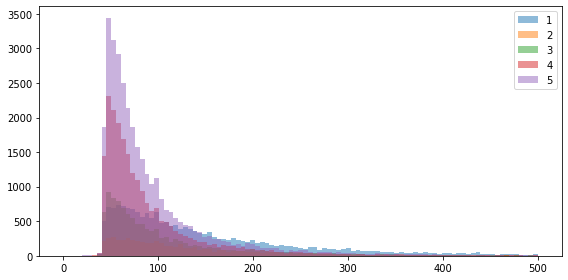

In [22]:
plot_histograms_byclass(df_train, 'rating', 'review_text_len', bins_max=500)

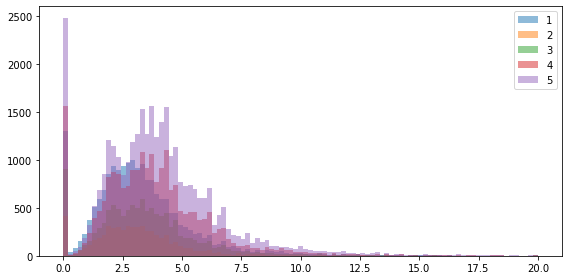

In [23]:
plot_histograms_byclass(df_train, 'rating', 'review_text_punct%', bins_max=20)

In [24]:
# Positive and Negative essence of sentences:
positive_values = df_train[df_train['rating'] == 5]['review_text'].values
w_ess = WordsEssence(max_features=200, ngram_range=(1, 3))
w_ess.fit(positive_values)
df_train['positeveness_index'] = w_ess.transform(df_train['review_text'].values)

negative_values = df_train[df_train['rating'] == 1]['review_text'].values
w_ess = WordsEssence(max_features=200, ngram_range=(1, 3))
w_ess.fit(negative_values)
df_train['negativeness_index'] = w_ess.transform(df_train['review_text'].values)

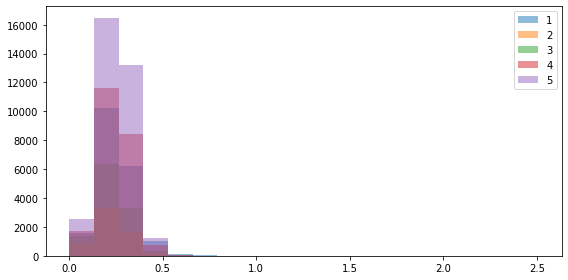

In [26]:
plot_histograms_byclass(df_train, 'rating', 'positeveness_index', bins_min=df_train['positeveness_index'].min(),
                        bins_max=df_train['positeveness_index'].max(), n_bins=20)

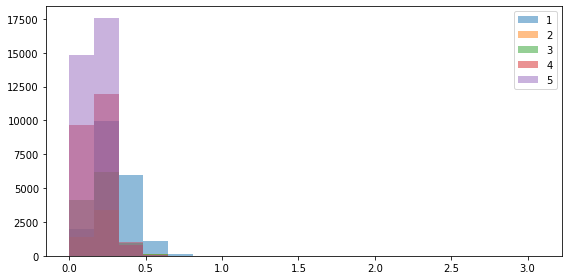

In [27]:
plot_histograms_byclass(df_train, 'rating', 'negativeness_index', bins_min=df_train['negativeness_index'].min(),
                        bins_max=df_train['negativeness_index'].max(), n_bins=20)

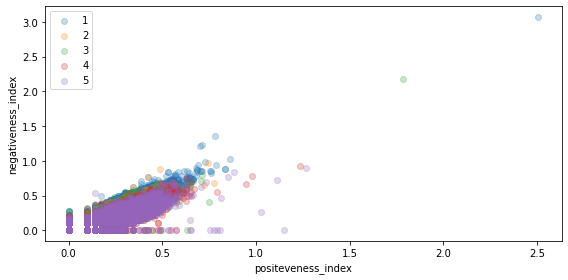

In [28]:
plot_scatter_byclass(df_train, 'rating', ('positeveness_index', 'negativeness_index'), alpha=0.25)